In [1]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
# ensemble 위한 분류학습기 추가하기
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import VotingClassifier


from sklearn.preprocessing import LabelEncoder , OneHotEncoder , StandardScaler , MinMaxScaler , Binarizer 
from sklearn.model_selection import train_test_split , GridSearchCV

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score , roc_auc_score
from sklearn.metrics import confusion_matrix, precision_recall_curve , roc_curve

import pandas as pd
import numpy  as np
import matplotlib.pyplot as plt
import seaborn as sns

import missingno as ms
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

# datasets
from sklearn.datasets import load_breast_cancer

## RandomForest(Bagging)

### 장점 
- 앙상블방식의 알고리즘 중 수행속도가 빠르다
- 다양한 데이터세트에서의 좋은 성능

### 단점
- 튜닝을 위한 시간이 오래 걸린다

In [12]:
def get_new_feature_name_df(old_feature_name_df):
    feature_dup_df = pd.DataFrame(data=old_feature_name_df.groupby('column_name').cumcount(), columns=['dup_cnt'])
    feature_dup_df = feature_dup_df.reset_index()
    new_feature_name_df = pd.merge(old_feature_name_df.reset_index(), feature_dup_df, how='outer')
    new_feature_name_df['column_name'] = new_feature_name_df[['column_name', 'dup_cnt']].apply(lambda x : x[0]+'_'+str(x[1]) 
                                                                                           if x[1] >0 else x[0] ,  axis=1)
    new_feature_name_df = new_feature_name_df.drop(['index'], axis=1)
    return new_feature_name_df


In [13]:
# 중복 피처에 대한 에러처리 구문
new_feature_name_df = get_new_feature_name_df(feature_name_df)
new_feature_name_df.head()

,column_index,column_name,dup_cnt
0,1,tBodyAcc-mean()-X,0
1,2,tBodyAcc-mean()-Y,0
2,3,tBodyAcc-mean()-Z,0
3,4,tBodyAcc-std()-X,0
4,5,tBodyAcc-std()-Y,0


In [16]:
# 데이터 프레임에 피처명을 컬럼으로 부여하기 위해 리스트 객체로 다시 반환
feature_name = new_feature_name_df.iloc[:,1].values.tolist()

In [5]:
feature_name_df = pd.read_csv('./data/features.txt', sep='\s+',
                                                     header=None, names=['column_index', 'column_name'])

feature_name_df.head()

,column_index,column_name
0,1,tBodyAcc-mean()-X
1,2,tBodyAcc-mean()-Y
2,3,tBodyAcc-mean()-Z
3,4,tBodyAcc-std()-X
4,5,tBodyAcc-std()-Y


In [23]:
# 데이터프레임에 피처명을 컬럼으로 뷰여하기 위해 리스트 객체로 다시 반환
feature_name = feature_name_df.iloc[:, 1].values.tolist()

In [22]:
X_train=pd.read_csv('./data/train/X_train.txt', sep='\s+',header=None,names=feature_name)
X_test = pd.read_csv('./data/test/X_test.txt', sep='\s+',header=None,names=feature_name)

# 학습 레이블과 테스트 레이블 데이터를 데이터 프레임으로 로딩, 컬럼명은 action으로 부여
y_train = pd.read_csv('./data/train/y_train.txt', sep='\s+', names=['action'])
y_test = pd.read_csv('./data/test/y_test.txt', sep='\s+', names=['action'])

In [26]:
# 랜덤포레스트 알고리즘을 이용한 학습/예측/평가
rf_model = RandomForestClassifier(random_state=0)
rf_model.fit(X_train,y_train)
y_pred = rf_model.predict(X_test)

In [27]:
print('answer',y_test)
print('guess',y_pred)
accuracy = accuracy_score(y_test,y_pred)
print('RF ACCURACY : ', accuracy)

answer       action
0          5
1          5
2          5
3          5
4          5
...      ...
2942       2
2943       2
2944       2
2945       2
2946       2

[2947 rows x 1 columns]
guess [5 5 5 ... 2 2 2]
RF ACCURACY :  0.9253478113335596


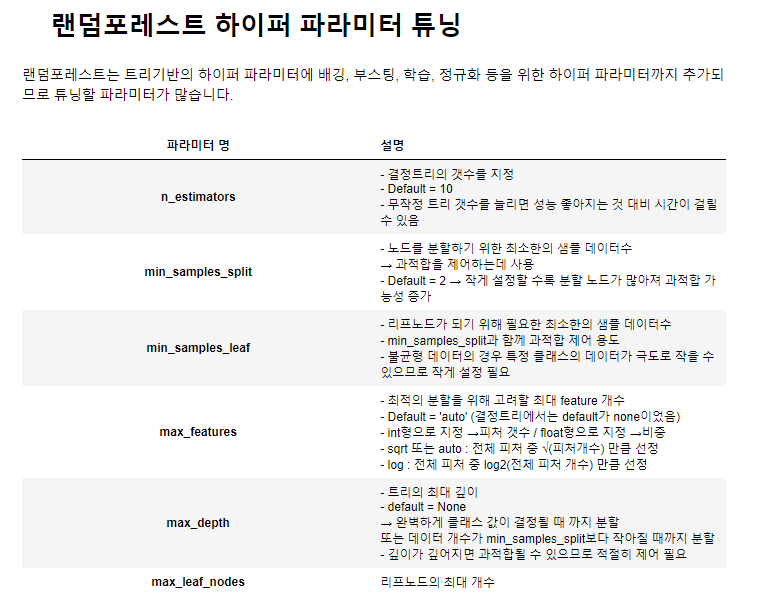

In [28]:
from IPython.display import Image
Image('./images/rf-03.png')

In [31]:
# GridSearchCV 교차검증 및 하이퍼 파라미터 튜닝

params = {
    'n_estimators' : [100],
    'max_depth' : [6,8,10,12], 
    'min_samples_leaf' :[8,12,18],
    'min_samples_split' : [8,16,20]
}

cv_rf_model = RandomForestClassifier(random_state=0,n_jobs=-1)
grid_cv = GridSearchCV(cv_rf_model, param_grid=params,cv=5,n_jobs=-1)
grid_cv.fit(X_train,y_train)

GridSearchCV(cv=5, estimator=RandomForestClassifier(n_jobs=-1, random_state=0),
             n_jobs=-1,
             param_grid={'max_depth': [6, 8, 10, 12],
                         'min_samples_leaf': [8, 12, 18],
                         'min_samples_split': [8, 16, 20],
                         'n_estimators': [100]})

In [32]:
print('최적의 파라미터 : ',grid_cv.best_params_)
print('예측 정확도 : ' , grid_cv.best_score_)

최적의 파라미터 :  {'max_depth': 12, 'min_samples_leaf': 12, 'min_samples_split': 8, 'n_estimators': 100}
예측 정확도 :  0.9269643030563687


In [37]:
# 최적의 하이퍼 파라미터를 이용하여 랜덤포레스트를 다시 학습시켜보기
hyper_rf_model = RandomForestClassifier(random_state=0, max_depth=12, min_samples_leaf =12, min_samples_split=8, n_estimators=100,n_jobs=-1)
hyper_rf_model.fit(X_train,y_train)
hyper_y_pred = rf_model.predict(X_test)

In [39]:
accuracy = accuracy_score(y_test,hyper_y_pred)
print('튜닝을 통한 예측정확도 : ', accuracy)

튜닝을 통한 예측정확도 :  0.9212758737699356


In [40]:
# 해당파라미터를 적용해서 예측 수행
best_params_dtc = grid_cv.best_estimator_
best_pred = best_params_dtc.predict(X_test)
accuracy = accuracy_score(y_test,best_pred)
print('예측 정확도 : ',accuracy)

예측 정확도 :  0.9212758737699356


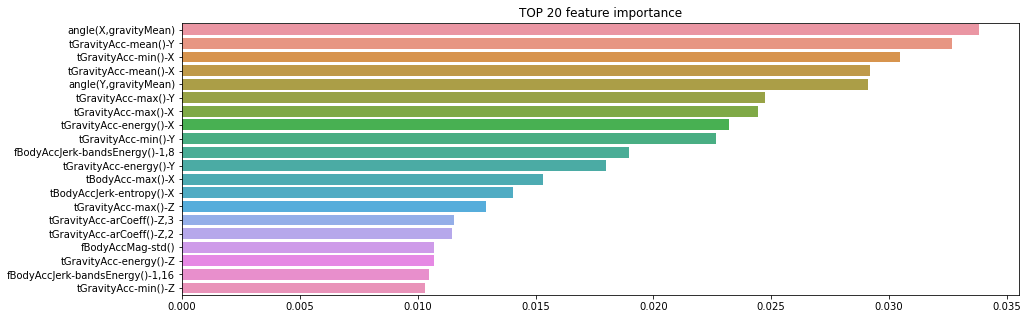

In [44]:
ftr_importance_values = hyper_rf_model.feature_importances_
ftr_importance = pd.Series(best_params_dtc.feature_importances_,index=X_train.columns)
ftr_top20=ftr_importance.sort_values(ascending=False)[:20]

plt.figure(figsize=(15,5))
plt.title('TOP 20 feature importance')
sns.barplot(x=ftr_top20,y=ftr_top20.index,data=df)
plt.show()